In [150]:
import torch
from torch import nn
from torch.distributions.multivariate_normal import MultivariateNormal
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as dists
import torch.utils.data as utils
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import os
import sys
import time
from collections import defaultdict
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import KDTree
import matplotlib as mpl
%matplotlib inline

In [69]:
class CSVAE(nn.Module):
    def __init__(self, input_dim, labels_dim, z_dim, w_dim):
        super(CSVAE, self).__init__()
        self.input_dim = input_dim
        self.labels_dim = labels_dim
        self.z_dim = z_dim
        self.w_dim = w_dim
        
        self.encoder_xy_to_w = nn.Sequential(nn.Linear(input_dim+labels_dim, w_dim), nn.ReLU(), nn.Linear(w_dim, w_dim), nn.ReLU())
        self.mu_xy_to_w = nn.Linear(w_dim, w_dim)
        self.logvar_xy_to_w = nn.Linear(w_dim, w_dim)
        
        self.encoder_x_to_z = nn.Sequential(nn.Linear(input_dim, z_dim), nn.ReLU(), nn.Linear(z_dim, z_dim), nn.ReLU())
        self.mu_x_to_z = nn.Linear(z_dim, z_dim)
        self.logvar_x_to_z = nn.Linear(z_dim, z_dim)
        
        self.encoder_y_to_w = nn.Sequential(nn.Linear(labels_dim, w_dim), nn.ReLU(), nn.Linear(w_dim, w_dim), nn.ReLU())
        self.mu_y_to_w = nn.Linear(w_dim, w_dim)
        self.logvar_y_to_w = nn.Linear(w_dim, w_dim)
        
        # Add sigmoid or smth for images!
        self.decoder_zw_to_x = nn.Sequential(nn.Linear(z_dim+w_dim, z_dim+w_dim), nn.ReLU(), nn.Linear(z_dim+w_dim, z_dim+w_dim), nn.ReLU())
        self.mu_zw_to_x = nn.Linear(z_dim+w_dim, input_dim)
        self.logvar_zw_to_x = nn.Linear(z_dim+w_dim, input_dim)
        
        self.decoder_z_to_y = nn.Sequential(nn.Linear(z_dim, z_dim), nn.ReLU(), nn.Linear(z_dim, z_dim), nn.ReLU(),
                                            nn.Linear(z_dim, labels_dim), nn.Sigmoid())

        self.init_params()

    def init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.xavier_normal_(m.weight.data)
        
    def q_zw(self, x, y):
        """
        VARIATIONAL POSTERIOR
        :param x: input image
        :return: parameters of q(z|x), (MB, hid_dim)
        """
        xy = torch.cat([x, y], dim=1)
        
        intermediate = self.encoder_x_to_z(x)
        z_mu = self.mu_x_to_z(intermediate)
        z_logvar = self.logvar_x_to_z(intermediate)
        
        intermediate = self.encoder_xy_to_w(xy)
        w_mu_encoder = self.mu_xy_to_w(intermediate)
        w_logvar_encoder = self.logvar_xy_to_w(intermediate)
        
        intermediate = self.encoder_y_to_w(y)
        w_mu_prior = self.mu_y_to_w(intermediate)
        w_logvar_prior = self.logvar_y_to_w(intermediate)
        
        return w_mu_encoder, w_logvar_encoder, w_mu_prior, \
               w_logvar_prior, z_mu, z_logvar
    
    def p_x(self, z, w):
        """
        GENERATIVE DISTRIBUTION
        :param z: latent vector          (MB, hid_dim)
        :return: parameters of p(x|z)    (MB, inp_dim)
        """
        
        zw = torch.cat([z, w], dim=1)
        
        intermediate = self.decoder_zw_to_x(zw)
        mu = self.mu_zw_to_x(intermediate)
        logvar = self.logvar_zw_to_x(intermediate)
        
        return mu, logvar

    def forward(self, x, y):
        """
        Encode the image, sample z and decode 
        :param x: input image
        :return: parameters of p(x|z_hat), z_hat, parameters of q(z|x)
        """
        w_mu_encoder, w_logvar_encoder, w_mu_prior, \
            w_logvar_prior, z_mu, z_logvar = self.q_zw(x, y)
        w_encoder = self.reparameterize(w_mu_encoder, w_logvar_encoder)
        w_prior = self.reparameterize(w_mu_prior, w_logvar_prior)
        z = self.reparameterize(z_mu, z_logvar)
        zw = torch.cat([z, w_encoder], dim=1)
        
        x_mu, x_logvar = self.p_x(z, w_encoder)
        y_pred = self.decoder_z_to_y(z)
        
        return x_mu, x_logvar, zw, y_pred, \
               w_mu_encoder, w_logvar_encoder, w_mu_prior, \
               w_logvar_prior, z_mu, z_logvar

    def calculate_loss(self, x, y):
        """
        Given the input batch, compute the negative ELBO 
        :param x:   (MB, inp_dim)
        :param beta: Float
        :param average: Compute average over mini batch or not, bool
        :return: -RE + beta * KL  (MB, ) or (1, )
        """
        x_mu, x_logvar, zw, y_pred, \
            w_mu_encoder, w_logvar_encoder, w_mu_prior, \
            w_logvar_prior, z_mu, z_logvar = self.forward(x, y)
        
        x_recon = nn.MSELoss()(x_mu, x)
        
        w_dist = dists.MultivariateNormal(w_mu_encoder.flatten(), torch.diag(w_logvar_encoder.flatten().exp()))
        w_prior = dists.MultivariateNormal(w_mu_prior.flatten(), torch.diag(w_logvar_prior.flatten().exp()))
        w_kl = dists.kl.kl_divergence(w_dist, w_prior)
        
        z_dist = dists.MultivariateNormal(z_mu.flatten(), torch.diag(z_logvar.flatten().exp()))
        z_prior = dists.MultivariateNormal(torch.zeros(self.z_dim * z_mu.size()[0]), torch.eye(self.z_dim * z_mu.size()[0]))
        z_kl = dists.kl.kl_divergence(z_dist, z_prior)
        
        y_pred_negentropy = (y_pred.log() * y_pred + (1-y_pred).log() * (1-y_pred)).mean()

        y_recon = 1 * nn.BCELoss()(y_pred, y)
        # alternatively use predicted logvar too to evaluate density of input
        
        # ELBO does not include y_recon because it should be optimized separately
        ELBO = 20 * x_recon + 0.2 * z_kl + 1 * w_kl + 10 * y_pred_negentropy
        
        return ELBO, x_recon, w_kl, z_kl, y_pred_negentropy, y_recon

#     def reconstruct_x(self, x, y):
#         x_mean, _, _, _, _ = self.forward(x, y)
#         return x_mean

#     def calculate_nll(self, X, samples=5000):
#         """
#         Estimate NLL by importance sampling
#         :param X: dataset, (N, inp_dim)
#         :param samples: Samples per observation
#         :return: IS estimate
#         """   
#         prob_sum = 0.

#         for i in range(samples):
#             KL, RE, _ = self.calculate_loss(X)
#             prob_sum += (KL + RE).exp_()
            
#         return - (prob_sum / samples).sum().log_()

#     def generate_x(self, N=25):
#         """
#         Sample, using you VAE: sample z from prior and decode it 
#         :param N: number of samples
#         :return: X (N, inp_size)
#         """

#         m = MultivariateNormal(torch.zeros(self.z_dim + self.w_dim), torch.eye(self.z_dim + self.w_dim))
#         z = m.sample(sample_shape=torch.Size([N])) 
        
#         X, _ = self.p_x(z.cuda())
#         return X

    @staticmethod
    def reparameterize(mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.FloatTensor(std.size()).normal_().to(mu.device)
        return eps.mul(std).add_(mu)

In [70]:
z_dim = 2
w_dim = 2
batch_size = 32

In [71]:
x_train, manifold_x_train = make_swiss_roll(n_samples=10000)
x_train = x_train.astype(np.float32)
y_train = (x_train[:, 0:1] >= 10).astype(np.float32)

train_set_x_tensor = torch.from_numpy(x_train)
train_set_y_tensor = torch.from_numpy(y_train)
train_set = utils.TensorDataset(train_set_x_tensor, train_set_y_tensor)
train_loader = utils.DataLoader(train_set, batch_size=batch_size, shuffle=True)

In [72]:
x_test, manifold_x_test = make_swiss_roll(n_samples=10000)
x_test = x_test.astype(np.float32)
y_test = (x_test[:, 0:1] >= 10).astype(np.float32)

test_set_x_tensor = torch.from_numpy(x_test)
test_set_y_tensor = torch.from_numpy(y_test)
test_set = utils.TensorDataset(test_set_x_tensor, test_set_y_tensor)
test_loader = utils.DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [73]:
model = CSVAE(input_dim=x_train.shape[1], labels_dim=y_train.shape[1], z_dim=z_dim, w_dim=w_dim)
model = model.train()

In [74]:
params_without_delta = [param for name, param in model.named_parameters() if 'decoder_z_to_y' not in name]
params_delta = [param for name, param in model.named_parameters() if 'decoder_z_to_y' in name]

opt_without_delta = optim.Adam(params_without_delta, lr=(1e-3)/2)
scheduler_without_delta = optim.lr_scheduler.MultiStepLR(opt_without_delta, milestones=[pow(3, i) for i in range(7)], gamma=pow(0.1, 1/7))
opt_delta = optim.Adam(params_delta, lr=(1e-3)/2)
scheduler_delta = optim.lr_scheduler.MultiStepLR(opt_delta, milestones=[pow(3, i) for i in range(7)], gamma=pow(0.1, 1/7))
n_epochs = 2300

In [75]:
train_x_recon_losses = []
train_w_kl_losses = []
train_z_kl_losses = []
train_y_negentropy_losses = []
train_y_recon_losses = []

test_x_recon_losses = []
test_w_kl_losses = []
test_z_kl_losses = []
test_y_negentropy_losses = []
test_y_recon_losses = []

for epoch_i in trange(n_epochs):
    for cur_batch in train_loader:
        loss_val, x_recon_loss_val, w_kl_loss_val, z_kl_loss_val, y_negentropy_loss_val, y_recon_loss_val = model.calculate_loss(*cur_batch)
        
        # optimization could be done more precisely but less efficiently by only updating delta or other params on a batch
        
        opt_delta.zero_grad()
        y_recon_loss_val.backward(retain_graph=True)
        opt_delta.step()
        
        opt_without_delta.zero_grad()
        loss_val.backward()
        opt_without_delta.step()
        
        train_x_recon_losses.append(x_recon_loss_val.item())
        train_w_kl_losses.append(w_kl_loss_val.item())
        train_z_kl_losses.append(z_kl_loss_val.item())
        train_y_negentropy_losses.append(y_negentropy_loss_val.item())
        train_y_recon_losses.append(y_recon_loss_val.item())
    scheduler_without_delta.step()
    scheduler_delta.step()
    print(f'Epoch {epoch_i}')
    
    print('Train')
    print(f'MSE(x): {np.array(train_x_recon_losses[-len(train_loader):]).mean():.4f}')
    print(f'KL(w): {np.array(train_w_kl_losses[-len(train_loader):]).mean():.4f}')
    print(f'KL(z): {np.array(train_z_kl_losses[-len(train_loader):]).mean():.4f}')
    print(f'-H(y): {np.array(train_y_negentropy_losses[-len(train_loader):]).mean():.4f}')
    print(f'BCE(y): {np.array(train_z_kl_losses[-len(train_loader):]).mean():.4f}')
    
    for cur_batch in test_loader:
        loss_val, x_recon_loss_val, w_kl_loss_val, z_kl_loss_val, y_negentropy_loss_val, y_recon_loss_val = model.calculate_loss(*cur_batch)
        
        test_x_recon_losses.append(x_recon_loss_val.item())
        test_w_kl_losses.append(w_kl_loss_val.item())
        test_z_kl_losses.append(z_kl_loss_val.item())
        test_y_negentropy_losses.append(y_negentropy_loss_val.item())
        test_y_recon_losses.append(y_recon_loss_val.item())
        
    print('Test')
    print(f'MSE(x): {np.array(test_x_recon_losses[-len(train_loader):]).mean():.4f}')
    print(f'KL(w): {np.array(test_w_kl_losses[-len(train_loader):]).mean():.4f}')
    print(f'KL(z): {np.array(test_z_kl_losses[-len(train_loader):]).mean():.4f}')
    print(f'-H(y): {np.array(test_y_negentropy_losses[-len(train_loader):]).mean():.4f}')
    print(f'BCE(y): {np.array(test_z_kl_losses[-len(train_loader):]).mean():.4f}')
    
    print()





  0%|          | 0/2300 [00:00<?, ?it/s]

Epoch 0
Train
MSE(x): 194.0324
KL(w): 803978.4742
KL(z): 134.6784
-H(y): -0.6800
BCE(y): 134.6784






  0%|          | 1/2300 [00:06<4:14:33,  6.64s/it]

Test
MSE(x): 87.9093
KL(w): 205182.8058
KL(z): 54.8414
-H(y): -0.6679
BCE(y): 54.8414

Epoch 1
Train
MSE(x): 77.4523
KL(w): 145563.1732
KL(z): 34.8305
-H(y): -0.6535
BCE(y): 34.8305






  0%|          | 2/2300 [00:13<4:21:26,  6.83s/it]

Test
MSE(x): 69.4078
KL(w): 100583.7956
KL(z): 22.2719
-H(y): -0.6356
BCE(y): 22.2719

Epoch 2
Train
MSE(x): 63.5004
KL(w): 79160.4815
KL(z): 17.4389
-H(y): -0.6085
BCE(y): 17.4389






  0%|          | 3/2300 [00:20<4:19:44,  6.78s/it]

Test
MSE(x): 60.2732
KL(w): 60845.6780
KL(z): 15.7226
-H(y): -0.5773
BCE(y): 15.7226

Epoch 3
Train
MSE(x): 57.8605
KL(w): 53197.8369
KL(z): 16.0597
-H(y): -0.5507
BCE(y): 16.0597






  0%|          | 4/2300 [00:27<4:24:25,  6.91s/it]

Test
MSE(x): 55.9926
KL(w): 45251.6533
KL(z): 17.1951
-H(y): -0.5262
BCE(y): 17.1951

Epoch 4
Train
MSE(x): 54.2743
KL(w): 40192.5186
KL(z): 18.8301
-H(y): -0.5048
BCE(y): 18.8301






  0%|          | 5/2300 [00:33<4:16:06,  6.70s/it]

Test
MSE(x): 53.1999
KL(w): 34744.8262
KL(z): 20.8673
-H(y): -0.4861
BCE(y): 20.8673

Epoch 5
Train
MSE(x): 50.4781
KL(w): 31240.1526
KL(z): 23.3257
-H(y): -0.4696
BCE(y): 23.3257






  0%|          | 6/2300 [00:40<4:18:22,  6.76s/it]

Test
MSE(x): 49.6185
KL(w): 27434.5673
KL(z): 25.7802
-H(y): -0.4607
BCE(y): 25.7802

Epoch 6
Train
MSE(x): 48.2918
KL(w): 24838.6356
KL(z): 28.3337
-H(y): -0.4514
BCE(y): 28.3337






  0%|          | 7/2300 [00:47<4:14:35,  6.66s/it]

Test
MSE(x): 46.8540
KL(w): 22005.9740
KL(z): 30.8848
-H(y): -0.4464
BCE(y): 30.8848

Epoch 7
Train
MSE(x): 46.4443
KL(w): 20116.7534
KL(z): 33.6179
-H(y): -0.4396
BCE(y): 33.6179






  0%|          | 8/2300 [00:54<4:25:45,  6.96s/it]

Test
MSE(x): 44.9088
KL(w): 17951.0205
KL(z): 36.1878
-H(y): -0.4399
BCE(y): 36.1878

Epoch 8
Train
MSE(x): 43.9380
KL(w): 16533.4834
KL(z): 39.2522
-H(y): -0.4363
BCE(y): 39.2522






  0%|          | 9/2300 [01:01<4:25:49,  6.96s/it]

Test
MSE(x): 42.9295
KL(w): 14853.9175
KL(z): 42.1102
-H(y): -0.4356
BCE(y): 42.1102

Epoch 9
Train
MSE(x): 42.0834
KL(w): 14074.9691
KL(z): 44.6641
-H(y): -0.4354
BCE(y): 44.6641






  0%|          | 10/2300 [01:08<4:18:08,  6.76s/it]

Test
MSE(x): 41.4917
KL(w): 13015.7752
KL(z): 46.6767
-H(y): -0.4347
BCE(y): 46.6767

Epoch 10
Train
MSE(x): 40.6040
KL(w): 12328.9958
KL(z): 49.1221
-H(y): -0.4347
BCE(y): 49.1221






  0%|          | 11/2300 [01:14<4:16:13,  6.72s/it]

Test
MSE(x): 40.2879
KL(w): 11398.8657
KL(z): 51.2581
-H(y): -0.4375
BCE(y): 51.2581

Epoch 11
Train
MSE(x): 39.8364
KL(w): 10796.0845
KL(z): 53.4557
-H(y): -0.4359
BCE(y): 53.4557






  1%|          | 12/2300 [01:21<4:12:43,  6.63s/it]

Test
MSE(x): 39.1531
KL(w): 9980.3081
KL(z): 55.6881
-H(y): -0.4355
BCE(y): 55.6881

Epoch 12
Train
MSE(x): 38.6351
KL(w): 9457.7509
KL(z): 58.1716
-H(y): -0.4351
BCE(y): 58.1716






  1%|          | 13/2300 [01:27<4:11:39,  6.60s/it]

Test
MSE(x): 38.2204
KL(w): 8743.0788
KL(z): 60.5389
-H(y): -0.4356
BCE(y): 60.5389

Epoch 13
Train
MSE(x): 37.1846
KL(w): 8292.0216
KL(z): 62.1424
-H(y): -0.4351
BCE(y): 62.1424






  1%|          | 14/2300 [01:35<4:20:53,  6.85s/it]

Test
MSE(x): 37.1597
KL(w): 7676.7133
KL(z): 63.6600
-H(y): -0.4364
BCE(y): 63.6600

Epoch 14
Train
MSE(x): 36.4899
KL(w): 7274.9248
KL(z): 64.2463
-H(y): -0.4354
BCE(y): 64.2463






  1%|          | 15/2300 [01:41<4:18:10,  6.78s/it]

Test
MSE(x): 36.2684
KL(w): 6733.8741
KL(z): 64.1400
-H(y): -0.4346
BCE(y): 64.1400

Epoch 15
Train
MSE(x): 35.8600
KL(w): 6388.4375
KL(z): 64.4236
-H(y): -0.4340
BCE(y): 64.4236






  1%|          | 16/2300 [01:48<4:19:05,  6.81s/it]

Test
MSE(x): 35.3988
KL(w): 5914.7740
KL(z): 64.2903
-H(y): -0.4320
BCE(y): 64.2903

Epoch 16
Train
MSE(x): 34.6772
KL(w): 5615.5770
KL(z): 64.5597
-H(y): -0.4308
BCE(y): 64.5597






  1%|          | 17/2300 [01:55<4:16:46,  6.75s/it]

Test
MSE(x): 34.5318
KL(w): 5200.7703
KL(z): 65.0800
-H(y): -0.4282
BCE(y): 65.0800

Epoch 17
Train
MSE(x): 33.9535
KL(w): 4940.1758
KL(z): 66.7412
-H(y): -0.4272
BCE(y): 66.7412






  1%|          | 18/2300 [02:01<4:09:02,  6.55s/it]

Test
MSE(x): 33.7628
KL(w): 4578.1824
KL(z): 66.9671
-H(y): -0.4253
BCE(y): 66.9671

Epoch 18
Train
MSE(x): 32.9765
KL(w): 4351.4116
KL(z): 68.4421
-H(y): -0.4238
BCE(y): 68.4421






  1%|          | 19/2300 [02:08<4:16:27,  6.75s/it]

Test
MSE(x): 32.6092
KL(w): 4033.7991
KL(z): 68.9815
-H(y): -0.4232
BCE(y): 68.9815

Epoch 19
Train
MSE(x): 31.8166
KL(w): 3838.5059
KL(z): 70.7708
-H(y): -0.4221
BCE(y): 70.7708






  1%|          | 20/2300 [02:15<4:21:40,  6.89s/it]

Test
MSE(x): 31.6231
KL(w): 3561.5549
KL(z): 71.9657
-H(y): -0.4193
BCE(y): 71.9657

Epoch 20
Train
MSE(x): 30.8355
KL(w): 3389.1979
KL(z): 73.5470
-H(y): -0.4176
BCE(y): 73.5470






  1%|          | 21/2300 [02:22<4:23:51,  6.95s/it]

Test
MSE(x): 30.3927
KL(w): 3146.6448
KL(z): 75.5983
-H(y): -0.4159
BCE(y): 75.5983

Epoch 21
Train
MSE(x): 29.6469
KL(w): 2995.7753
KL(z): 78.3025
-H(y): -0.4151
BCE(y): 78.3025






  1%|          | 22/2300 [02:29<4:17:38,  6.79s/it]

Test
MSE(x): 29.1742
KL(w): 2782.6852
KL(z): 81.3125
-H(y): -0.4130
BCE(y): 81.3125

Epoch 22
Train
MSE(x): 28.4111
KL(w): 2650.8184
KL(z): 85.6322
-H(y): -0.4116
BCE(y): 85.6322






  1%|          | 23/2300 [02:35<4:15:29,  6.73s/it]

Test
MSE(x): 27.9454
KL(w): 2461.5742
KL(z): 90.6195
-H(y): -0.4105
BCE(y): 90.6195

Epoch 23
Train
MSE(x): 26.9005
KL(w): 2347.4717
KL(z): 96.1649
-H(y): -0.4094
BCE(y): 96.1649






  1%|          | 24/2300 [02:42<4:10:16,  6.60s/it]

Test
MSE(x): 26.6636
KL(w): 2179.9537
KL(z): 100.7002
-H(y): -0.4080
BCE(y): 100.7002

Epoch 24
Train
MSE(x): 25.9742
KL(w): 2079.7345
KL(z): 105.5747
-H(y): -0.4059
BCE(y): 105.5747






  1%|          | 25/2300 [02:48<4:05:29,  6.47s/it]

Test
MSE(x): 25.7588
KL(w): 1933.5343
KL(z): 108.3728
-H(y): -0.4055
BCE(y): 108.3728

Epoch 25
Train
MSE(x): 25.2183
KL(w): 1844.5465
KL(z): 112.3087
-H(y): -0.4053
BCE(y): 112.3087






  1%|          | 26/2300 [02:55<4:12:08,  6.65s/it]

Test
MSE(x): 25.1019
KL(w): 1715.8460
KL(z): 115.4623
-H(y): -0.4041
BCE(y): 115.4623

Epoch 26
Train
MSE(x): 24.6651
KL(w): 1636.4508
KL(z): 117.5236
-H(y): -0.4029
BCE(y): 117.5236






  1%|          | 27/2300 [03:02<4:12:05,  6.65s/it]

Test
MSE(x): 24.7129
KL(w): 1520.8902
KL(z): 117.2624
-H(y): -0.4036
BCE(y): 117.2624

Epoch 27
Train
MSE(x): 24.2320
KL(w): 1475.8650
KL(z): 118.2488
-H(y): -0.4029
BCE(y): 118.2488






  1%|          | 28/2300 [03:09<4:15:21,  6.74s/it]

Test
MSE(x): 24.5000
KL(w): 1394.5529
KL(z): 120.4022
-H(y): -0.4022
BCE(y): 120.4022

Epoch 28
Train
MSE(x): 24.0304
KL(w): 1350.2692
KL(z): 122.0176
-H(y): -0.4021
BCE(y): 122.0176






  1%|▏         | 29/2300 [03:16<4:20:53,  6.89s/it]

Test
MSE(x): 24.1897
KL(w): 1273.8679
KL(z): 122.4140
-H(y): -0.4012
BCE(y): 122.4140

Epoch 29
Train
MSE(x): 23.8406
KL(w): 1232.2312
KL(z): 123.5336
-H(y): -0.4015
BCE(y): 123.5336






  1%|▏         | 30/2300 [03:23<4:25:12,  7.01s/it]

Test
MSE(x): 23.9433
KL(w): 1161.9984
KL(z): 123.6124
-H(y): -0.4014
BCE(y): 123.6124

Epoch 30
Train
MSE(x): 23.5852
KL(w): 1122.4055
KL(z): 125.0088
-H(y): -0.4024
BCE(y): 125.0088






  1%|▏         | 31/2300 [03:30<4:27:33,  7.08s/it]

Test
MSE(x): 23.6824
KL(w): 1056.1707
KL(z): 125.2365
-H(y): -0.4008
BCE(y): 125.2365

Epoch 31
Train
MSE(x): 23.2290
KL(w): 1019.0572
KL(z): 126.4020
-H(y): -0.4011
BCE(y): 126.4020






  1%|▏         | 32/2300 [03:38<4:31:38,  7.19s/it]

Test
MSE(x): 23.5847
KL(w): 957.5830
KL(z): 126.3795
-H(y): -0.4002
BCE(y): 126.3795

Epoch 32
Train
MSE(x): 23.2854
KL(w): 923.4597
KL(z): 127.9399
-H(y): -0.4003
BCE(y): 127.9399






  1%|▏         | 33/2300 [03:45<4:26:51,  7.06s/it]

Test
MSE(x): 23.3615
KL(w): 868.1503
KL(z): 128.2512
-H(y): -0.3997
BCE(y): 128.2512

Epoch 33
Train
MSE(x): 22.9942
KL(w): 836.2812
KL(z): 129.1741
-H(y): -0.4004
BCE(y): 129.1741






  1%|▏         | 34/2300 [03:51<4:23:45,  6.98s/it]

Test
MSE(x): 23.1102
KL(w): 784.7732
KL(z): 129.0117
-H(y): -0.3990
BCE(y): 129.0117



KeyboardInterrupt: 

In [ ]:
x_test, manifold_x_test = make_swiss_roll(n_samples=10000)
x_test = x_test.astype(np.float32)
test_set_tensor = torch.from_numpy(x_test)
# mu_x, logvar_x, z_hat, mu_z, logvar_z = model.forward(test_set_tensor)

# labels_test = (x_test[:, 0:1] >= 10)
# colors_test = ['red' if label[0] else 'blue' for label in labels_test]

# z_hat = z_hat.detach().numpy()
# z_comp = z_hat[:, :2]
# w_comp = z_hat[:, 2:]

In [ ]:
x_test, manifold_x_test = make_swiss_roll(n_samples=10000)

In [ ]:
# Usual VAE results

plt.figure(figsize=(5, 5,))
plt.title('(z1, z2)')
plt.scatter(z_comp[:, 0], z_comp[:, 1], c=colors_test)

plt.figure(figsize=(5, 5,))
plt.title('(z2, w1)')
plt.scatter(z_comp[:, 1], w_comp[:, 0], c=colors_test)

plt.figure(figsize=(5, 5,))
plt.title('(w1, w2)')
plt.scatter(w_comp[:, 0], w_comp[:, 1], c=colors_test)

plt.figure(figsize=(5, 5,))
plt.title('(w2, z1)')
plt.scatter(w_comp[:, 1], w_comp[:, 0], c=colors_test)

In [137]:
def knn_distance(point, sample, k):
    """ Euclidean distance from `point` to it's `k`-Nearest
    Neighbour in `sample` """
    norms = np.linalg.norm(sample-point, axis=1)
    return np.sort(norms)[k]


def verify_sample_shapes(s1, s2, k):
    # Expects [N, D]
    assert(len(s1.shape) == len(s2.shape) == 2)
    # Check dimensionality of sample is identical
    assert(s1.shape[1] == s2.shape[1])
    
def scipy_estimator(s1, s2, k=1):
    """ KL-Divergence estimator using scipy's KDTree
        s1: (N_1,D) Sample drawn from distribution P
        s2: (N_2,D) Sample drawn from distribution Q
        k: Number of neighbours considered (default 1)
        return: estimated D(P|Q)
    """
    verify_sample_shapes(s1, s2, k)

    n, m = len(s1), len(s2)
    d = float(s1.shape[1])
    D = np.log(m / (n - 1))

    nu_d,  nu_i   = KDTree(s2).query(s1, k)
    rho_d, rhio_i = KDTree(s1).query(s1, k+1)

    # KTree.query returns different shape in k==1 vs k > 1
    if k > 1:
        D += (d/n)*np.sum(np.log(nu_d[::, -1]/rho_d[::, -1]))
    else:
        D += (d/n)*np.sum(np.log(nu_d/rho_d[::, -1]))

    return D


def skl_estimator(s1, s2, k=1):
    """ KL-Divergence estimator using scikit-learn's NearestNeighbours
        s1: (N_1,D) Sample drawn from distribution P
        s2: (N_2,D) Sample drawn from distribution Q
        k: Number of neighbours considered (default 1)
        return: estimated D(P|Q)
    """
    verify_sample_shapes(s1, s2, k)

    n, m = len(s1), len(s2)
    d = float(s1.shape[1])
    D = np.log(m / (n - 1))

    s1_neighbourhood = NearestNeighbors(k+1, 10).fit(s1)
    s2_neighbourhood = NearestNeighbors(k, 10).fit(s2)

    for p1 in s1:
        s1_distances, indices = s1_neighbourhood.kneighbors([p1], k+1)
        s2_distances, indices = s2_neighbourhood.kneighbors([p1], k)
        rho = s1_distances[0][-1]
        nu = s2_distances[0][-1]
        D += (d/n)*np.log(nu/rho)
    return D

In [161]:
from definitions import VAE, CSVAE_without_delta_net, CSVAE

In [185]:
path = '/home/aglyzhov/latent-subspaces/csvae_toy/res/csvae_full_save/models/model_{epoch_i}.pt'
method_name = 'CSVAE'
state_dict = torch.load(path, map_location='cpu')
model = CSVAE(input_dim=x_train.shape[1], labels_dim=y_train.shape[1], z_dim=z_dim, w_dim=w_dim)
model = model.eval()

# path = '/home/aglyzhov/latent-subspaces/csvae_toy/res/csvae_without_delta_net_full_save/models/model_{epoch_i}.pt'
# method_name = 'CSVAE_without_delta_net'
# state_dict = torch.load(path, map_location='cpu')
# model = CSVAE_without_delta_net(input_dim=x_train.shape[1], labels_dim=y_train.shape[1], z_dim=z_dim, w_dim=w_dim)
# model = model.eval()

# path = '/home/aglyzhov/latent-subspaces/csvae_toy/res/vae_full_save/models/model_{epoch_i}.pt'
# method_name = 'VAE'
# state_dict = torch.load(path, map_location='cpu')
# model = VAE(input_dim=x_train.shape[1], z_dim=z_dim, w_dim=w_dim, beta=1)
# model = model.eval()

In [186]:
incomp_keys = model.load_state_dict(state_dict)

In [187]:
x_test, manifold_x_test = make_swiss_roll(n_samples=10000)
x_test = x_test.astype(np.float32)
y_test = (x_test[:, 0:1] >= 10).astype(np.float32)

test_set_x_tensor = torch.from_numpy(x_test)
test_set_y_tensor = torch.from_numpy(y_test)
test_set = utils.TensorDataset(test_set_x_tensor, test_set_y_tensor)
test_loader = utils.DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [188]:
epoch_i = 2300

In [189]:
label_size = 20
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size

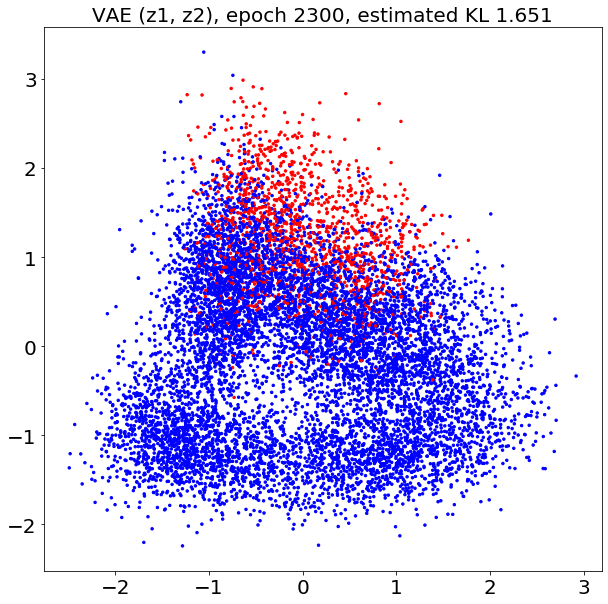

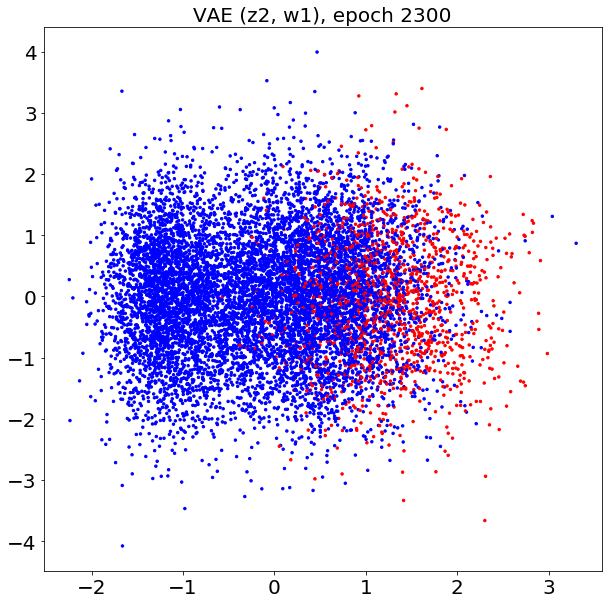

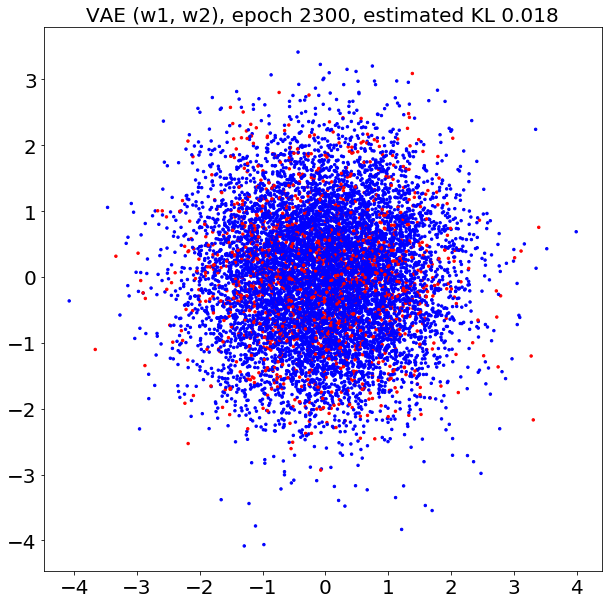

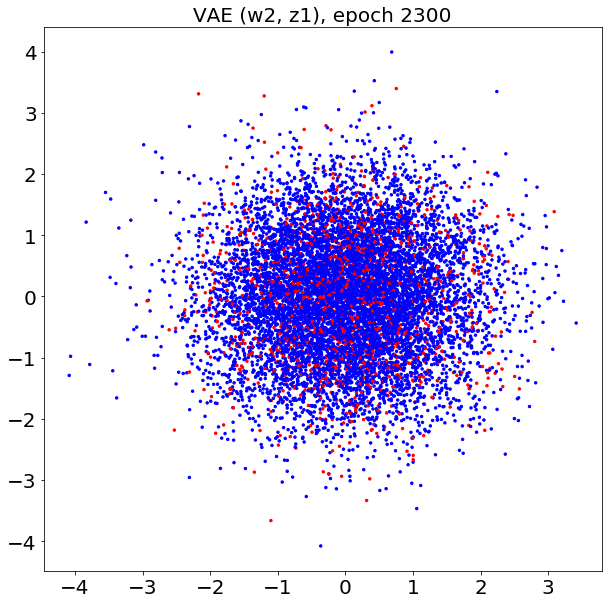

In [184]:
if method_name == 'CSVAE':
    _, _, zw, _, _, _, _, _, _, _ = model.forward(test_set_x_tensor, test_set_y_tensor)
elif method_name == 'CSVAE_without_delta_net':
    _, _, zw, _, _, _, _, _, _ = model.forward(test_set_x_tensor, test_set_y_tensor)
elif method_name == 'VAE':
    _, _, zw, _, _ = model.forward(test_set_x_tensor)


colors_test = ['red' if label else 'blue' for label in y_test]

zw = zw.detach().cpu().numpy()
z_comp = zw[:, :2]
w_comp = zw[:, 2:]

z_true = zw[y_test.astype(bool)[:, 0], :2]
w_true = zw[y_test.astype(bool)[:, 0], 2:]
z_false = zw[~y_test.astype(bool)[:, 0], :2]
w_false = zw[~y_test.astype(bool)[:, 0], 2:]
z_kl = scipy_estimator(z_true, z_false)
w_kl = scipy_estimator(w_true, w_false)

scatter_size = 6
figsize=(10, 10)

cur_title = f'{method_name} (z1, z2), epoch {epoch_i}, estimated KL {z_kl:.3f}'
plt.figure(figsize=figsize)
plt.title(cur_title, fontsize=20)
plt.scatter(z_comp[:, 0], z_comp[:, 1], c=colors_test, s=scatter_size)
# plt.savefig(os.path.join(vis_dir, cur_title))

cur_title = f'{method_name} (z2, w1), epoch {epoch_i}'
plt.figure(figsize=figsize)
plt.title(cur_title, fontsize=20)
plt.scatter(z_comp[:, 1], w_comp[:, 0], c=colors_test, s=scatter_size)
# plt.savefig(os.path.join(vis_dir, cur_title))

cur_title = f'{method_name} (w1, w2), epoch {epoch_i}, estimated KL {w_kl:.3f}'
plt.figure(figsize=figsize)
plt.title(cur_title, fontsize=20)
plt.scatter(w_comp[:, 0], w_comp[:, 1], c=colors_test, s=scatter_size)
# plt.savefig(os.path.join(vis_dir, cur_title))

cur_title = f'{method_name} (w2, z1), epoch {epoch_i}'
plt.figure(figsize=figsize)
plt.title(cur_title, fontsize=20)
plt.scatter(w_comp[:, 1], w_comp[:, 0], c=colors_test, s=scatter_size)
# plt.savefig(os.path.join(vis_dir, cur_title))

# plt.close('all')

In [190]:
x_mean, _, zw, _, _, _, _, _, _, _ = model.forward(test_set_x_tensor, test_set_y_tensor)

In [ ]:
# reconstruction quality is nil! haha

In [193]:
test_set_x_tensor - x_mean

tensor([[-1.0423,  1.0788,  0.9411],
        [ 5.5853, -6.9114, -2.5889],
        [ 7.4923,  1.9619, -5.0630],
        ...,
        [ 4.5855,  2.5094, -6.6964],
        [-2.6882, -1.3055,  0.9107],
        [ 2.9522, -7.1582, -7.6561]], grad_fn=<SubBackward0>)